In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
feature_monthly_ = pd.read_csv('./tmp/feature_monthly_.csv',encoding='gbk',index_col=0)

In [4]:
data_test = pd.read_csv('./test.csv')

In [5]:
# 使用滞后平移操作，丢弃了前三个月的数据
train_set = feature_monthly_.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = feature_monthly_.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = feature_monthly_.query('date_block_num == 33').copy()
 
train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)
 
train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

对商店，商品，年和月构造销量的均值特征

In [6]:
# Shop mean
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean 
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)
# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [7]:
# 构建X，y
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [8]:
int_features = ['shop_id', 'item_id', 'year', 'month']
X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

对测试集进行缺失特征的填充，填充规则为最近的一个月的特征

In [9]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
#latest_records为每个shop_id,item_id组合的最新的特征记录，如果每验证集的最后一个月出现了某种组合，则该组合特征记录一定是在最有一个月，如果最后一个月没有，则找最近的一个月份的
X_test = pd.merge(data_test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])  #让每个组合拥有最近的记录

In [10]:
X_test['year'] = 2015
X_test['month'] = 11
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [16]:
# 删掉品类id
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [77]:
# 保存训练集，验证集和测试集
X_train.to_csv('./datasets/X_train.csv')
X_validation.to_csv('./datasets/X_validation.csv')
X_test.to_csv('./datasets/X_test.csv')

In [78]:
Y_train.to_csv('./datasets/Y_train.csv')
Y_validation.to_csv('./datasets/Y_validation.csv')

In [25]:
from catboost import CatBoostRegressor
cat_features = [0, 1, 7, 8]
 
catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)
 
catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

Learning rate set to 0.359493
0:	learn: 0.6981646	test: 0.7106132	best: 0.7106132 (0)	total: 5.1s	remaining: 42m 26s
50:	learn: 0.1308273	test: 0.1598689	best: 0.1598689 (50)	total: 2m 41s	remaining: 23m 45s
100:	learn: 0.0874025	test: 0.1199434	best: 0.1199434 (100)	total: 5m	remaining: 19m 46s
150:	learn: 0.0667480	test: 0.1028085	best: 0.1027662 (149)	total: 7m 14s	remaining: 16m 44s
200:	learn: 0.0555717	test: 0.0960671	best: 0.0960671 (200)	total: 9m 32s	remaining: 14m 12s
250:	learn: 0.0472214	test: 0.0901467	best: 0.0901315 (249)	total: 11m 45s	remaining: 11m 39s
300:	learn: 0.0415827	test: 0.0872966	best: 0.0872966 (300)	total: 14m 2s	remaining: 9m 16s
350:	learn: 0.0375041	test: 0.0846717	best: 0.0846490 (347)	total: 16m 17s	remaining: 6m 54s
400:	learn: 0.0337629	test: 0.0831924	best: 0.0831705 (398)	total: 18m 29s	remaining: 4m 33s
450:	learn: 0.0310485	test: 0.0816798	best: 0.0816798 (450)	total: 20m 43s	remaining: 2m 15s
499:	learn: 0.0287284	test: 0.0810800	best: 0.081076

特征重要性

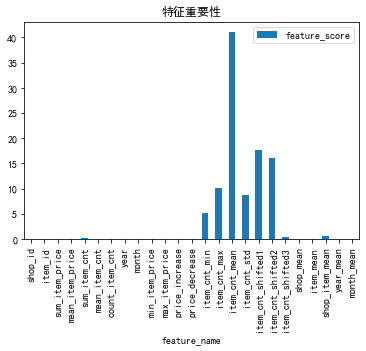

In [56]:
plt.rcParams['font.family'] = 'SimHei'
pd.concat([pd.DataFrame(data=np.array(catboost_model.feature_names_).reshape(-1,1),columns=['feature_name'])
           ,pd.DataFrame(data=catboost_model.feature_importances_,columns=['feature_score'])]
          ,axis=1).set_index('feature_name').plot(kind='bar')
plt.title('特征重要性')
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error as mse
Y_valid_pre = catboost_model.predict(X_validation)

In [35]:
# 拟合系数
catboost_model.score(X_train,Y_train)

0.9989572656506853

In [36]:
# RMSE
mse(Y_validation,Y_valid_pre) ** 0.5

0.08107601317625766

In [65]:
# 预测
Y_test_pre = catboost_model.predict(X_test).clip(0.,20.)

In [66]:
Y_test_pre

array([0.00000000e+00, 4.34159365e-05, 9.62900785e-01, ...,
       1.33551044e-04, 8.85263126e-04, 1.22320532e-04])

In [67]:
data_sub = pd.read_csv('./sample_submission.csv')
data_sub['item_cnt_month'] = y_test_pre

In [79]:
data_sub.to_csv('./Submission.csv',index=False)